## О данных

Будем работать с [датасетом физической активности](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones).

В этом датасете собраны данные 30 человек, выполняющих различные действия со смартфоном на поясе. Данные записывались с помощью датчиков (акселерометра и гироскопа) в этом смартфоне. Были зафиксированы: "3-осевое линейное ускорение" (_tAcc-XYZ_) и "3-осевая угловая скорость" (_tGyro-XYZ_).

1. Все сигналы отсортированы по времени, пропущены через фильтр шума.
2. Все наблюдения были разделены на окна по 128 сигналов в каждом, причем окна пересекаются на 50% (грубо говоря, с 1 по 128 сигнал в 1 окно, с 64 до 192 сигнала - во 2 окно и так далее). То есть каждое окно покрывает 2.56 секунды данных (два шага человека при ходьбе, учитывая медленную походку пожилых людей).
3. Линейное ускорение было разделено на две составляющие (с помощью низкочастотного фильтра): ускорение самого тела, а также гравитационная составляющая. Будем называть их ускорением тела и гравитационным ускорением.
4. К получившимся окнам применяли различные функции для получения следующих показателей:
    - max
    - min
    - mad (median)
    - mean
    - std
    - skewness (коэффициент асимметричности распределения признака в окне)
    - etc. (подробнее, на сколько это возможно, указано в [самой статье](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf))
5. Величина (magnitude) сигнала также определялась через евклидову норму всех значений из вектора для одного окна.
6. К окнам было применено преобразование Фурье, чтобы получить частоты. Из частот были извелченыте же показатели, плюс новые:
    - bandsEnergy (энергия частотного интервала)
7. Были посчитаны углы между векторами соответствующих окон.
8. Для ускорений были посчитаны производные - рывки, к которым применялись те же функции.

Итог: в датасете каждый признак - это какая-то операция над вектором из 128 чисел, которые соответствуют замерам определенного человека занятого какой-то активностью на протяжении 2.56 секунд.

Как читать названия признаков? Примеры:
- `tBodyAccMag-mean()` - это вектор ускорений тела (без гравитационной составляющей этого ускорения), из которого взяли евклидову норму, а затем усреднили, чтобы получить скаляр
- `fBodyAcc-bandsEnergy()-1,8.2` - это вектор ускорения тела, к которому применили преобразование Фурье, преобразовав его в вектор частот, а затем посчитали на этом векторе энергию данного частотного интервала в определенном диапазоне частот (в данном случае 1 - 8.2)
- `angle(X,gravityMean)` - это угол между осью Х и вектором усредненных значений гравитационного ускорения из соответствующего окна


## Предобработка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.shape

(7352, 563)

В датасете 563 признака, включая целевую переменную. Столько признаков нам не нужно. Сделаем подвыборку признаков для удобства работы с ними.

In [ ]:
cols_subset = [
    'tBodyAccMag-mean()',  # усредненная величина ускорения тела
    'tBodyGyroJerk-mad()-X',  # медианная величина рывка тела по оси Х
    'tGravityAcc-min()-X',  # минимум гравитационной составляющей ускорения по оси Х
    'tBodyAcc-max()-X',  # максимальная величина ускорения тела по оси Х
    'fBodyAcc-bandsEnergy()-1,8.2',  # энергия ускорения тела в интервале частоты
    'angle(X,gravityMean)',  # угол между осью Х и усредненной гравитационной составляющей ускорения
    'angle(Y,gravityMean)',  # угол между осью Y и усредненной гравитационной составляющей ускорения
    'angle(Z,gravityMean)',  # угол между осью Z и усредненной гравитационной составляющей ускорения,
    'fBodyAcc-skewness()-X',  # асимметричность частоты ускорения тела по оси Х
    'subject',  # номер испытуемого
    'Activity',  # название вида деятельности (целевая переменная)
]

In [ ]:
train = train[cols_subset]
test = test[cols_subset]

In [ ]:
print(f'Количество пропусков в train: {train.isnull().sum().sum()}')
print(f'Количество пропусков в test: {test.isnull().sum().sum()}')
print(f'Количество дублей в train: {train.duplicated().sum()}')
print(f'Количество дублей в test: {test.duplicated().sum()}')

Количество пропусков в train: 0
Количество пропусков в test: 0
Количество дублей в train: 0
Количество дублей в test: 0


Пропусков и дублей нет

In [ ]:
train.describe()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,-0.543884,-0.727735,0.678505,-0.468604,-0.847963,-0.489547,0.058593,-0.056515,-0.128562,17.413085
std,0.477653,0.315832,0.508656,0.544547,0.233633,0.511807,0.297480,0.279122,0.403686,8.975143
min,-1.000000,-0.999889,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.931208,1.000000
25%,-0.983282,-0.991595,0.804270,-0.936219,-0.999480,-0.812065,-0.017885,-0.143414,-0.486841,8.000000
50%,-0.883371,-0.950268,0.926693,-0.881637,-0.986582,-0.709417,0.182071,0.003181,-0.163271,19.000000
75%,-0.106892,-0.474625,0.965095,-0.017129,-0.764508,-0.509079,0.248353,0.107659,0.155112,26.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.478157,1.000000,1.000000,30.000000


Многие признаки имеют значения в диапазоне [ -1, 1], это значит, что они были нормализованы. \
Средние значения многих показателей отрицательные, значит данные смещены в отрицательную сторону.\
Стандартные отклонения достаточно большие у всех показателей, что говорит о значительном разбросе.



In [ ]:
train_cnt = train['Activity'].value_counts()
test_cnt = test['Activity'].value_counts()
print(f'\tДля train: \n{train_cnt}', f'\n\tДля test: \n{test_cnt}')

	Для train: 
Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64 
	Для test: 
Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64


In [ ]:
print(1 - min(train_cnt) / max(train_cnt))
print(1 - min(test_cnt) / max(test_cnt))

0.29921819474058275
0.2178770949720671


Можно увидеть, что разница не превышает 30%, значит данные в train и в test сбалансированы.

In [ ]:
train_corr = train.select_dtypes(include=['number']).corr()
train_corr

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject
tBodyAccMag-mean(),1.000000,0.899080,0.369962,0.959827,0.697832,-0.370849,0.495561,0.426283,0.379796,-0.073652
tBodyGyroJerk-mad()-X,0.899080,1.000000,0.380118,0.879900,0.507939,-0.382246,0.478567,0.380967,0.266002,-0.110321
tGravityAcc-min()-X,0.369962,0.380118,1.000000,0.380404,0.239088,-0.988663,0.797116,0.667415,-0.261676,-0.042371
tBodyAcc-max()-X,0.959827,0.879900,0.380404,1.000000,0.613383,-0.384192,0.480229,0.405023,0.335708,-0.055633
"fBodyAcc-bandsEnergy()-1,8.2",0.697832,0.507939,0.239088,0.613383,1.000000,-0.213318,0.363170,0.423927,0.260316,-0.037000
"angle(X,gravityMean)",-0.370849,-0.382246,-0.988663,-0.384192,-0.213318,1.000000,-0.783848,-0.643655,0.265523,0.026137
"angle(Y,gravityMean)",0.495561,0.478567,0.797116,0.480229,0.363170,-0.783848,1.000000,0.594885,-0.046213,-0.009829
"angle(Z,gravityMean)",0.426283,0.380967,0.667415,0.405023,0.423927,-0.643655,0.594885,1.000000,-0.183815,-0.098712
fBodyAcc-skewness()-X,0.379796,0.266002,-0.261676,0.335708,0.260316,0.265523,-0.046213,-0.183815,1.000000,0.019742
subject,-0.073652,-0.110321,-0.042371,-0.055633,-0.037000,0.026137,-0.009829,-0.098712,0.019742,1.000000


Сильную коррелюцию имеют показатели tBodyAccMag-mean() и tBodyGyroJerk-mad()-X, так как они отражают похожие свойства движения(ускорение и рывки).\
Очень высокая отрицательная корреляция между tGravityAcc-min()-X и angle(X,gravityMean), это могло возникнуть из-за того, что чем меньше гравитационное ускорение по X, тем больше угол наклона тела.\
Subject имеет очень низкие корреляции с другими переменными,так как номер испытуемого никак не влияет на параметры движения.


## Exploratory Data Analysis

Ранее мы уже проверили сбалансированность данных по разным категориям активностей в train и test сетах. Визуализируем количество сэмплов в каждой из категорий отдельно для train и test сетов.

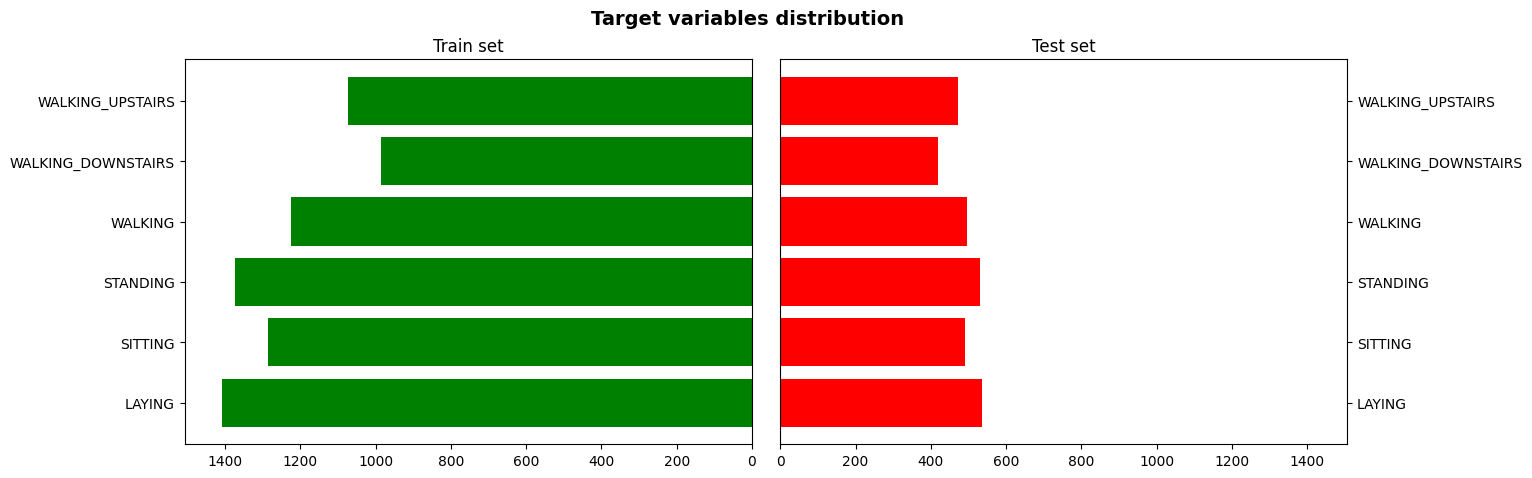

In [ ]:
categories = sorted((test['Activity']).unique())

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.05)
fig.suptitle("Target variables distribution", fontsize=14, fontweight="bold")

axes[0].barh(categories, train_cnt.sort_index(), color="green")
axes[0].set_title("Train set")
axes[0].set_xlim(0, max(train_cnt) + 100)
axes[0].invert_xaxis()

axes[1].barh(categories, test_cnt.sort_index(), color="red")
axes[1].set_title("Test set")
axes[1].set_xlim(0, max(train_cnt) + 100)
axes[1].set_yticklabels(categories)
axes[1].yaxis.tick_right()

plt.show()


На графиках отлично видно, что ни один класс не представлен слишком маленьким количеством наблюдений, также в test классы практически одикового размера.

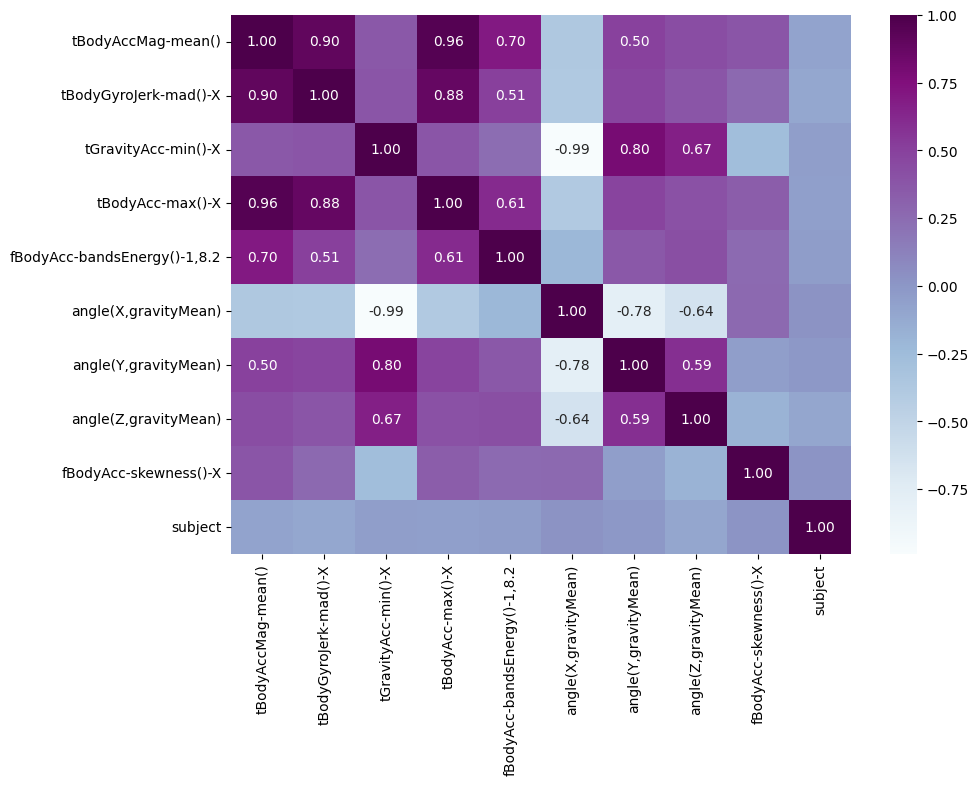

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(train_corr, cmap="BuPu", annot=True, fmt="0.2f")
for i in ax.texts:
    if abs(float(i.get_text())) >= 0.5:
        i.set_text(i.get_text())
    else:
        i.set_text("")
plt.show()

Subject стоит исключить из рассмотрения, так как номер испытуемого никак не должен влиять на параметры движения.

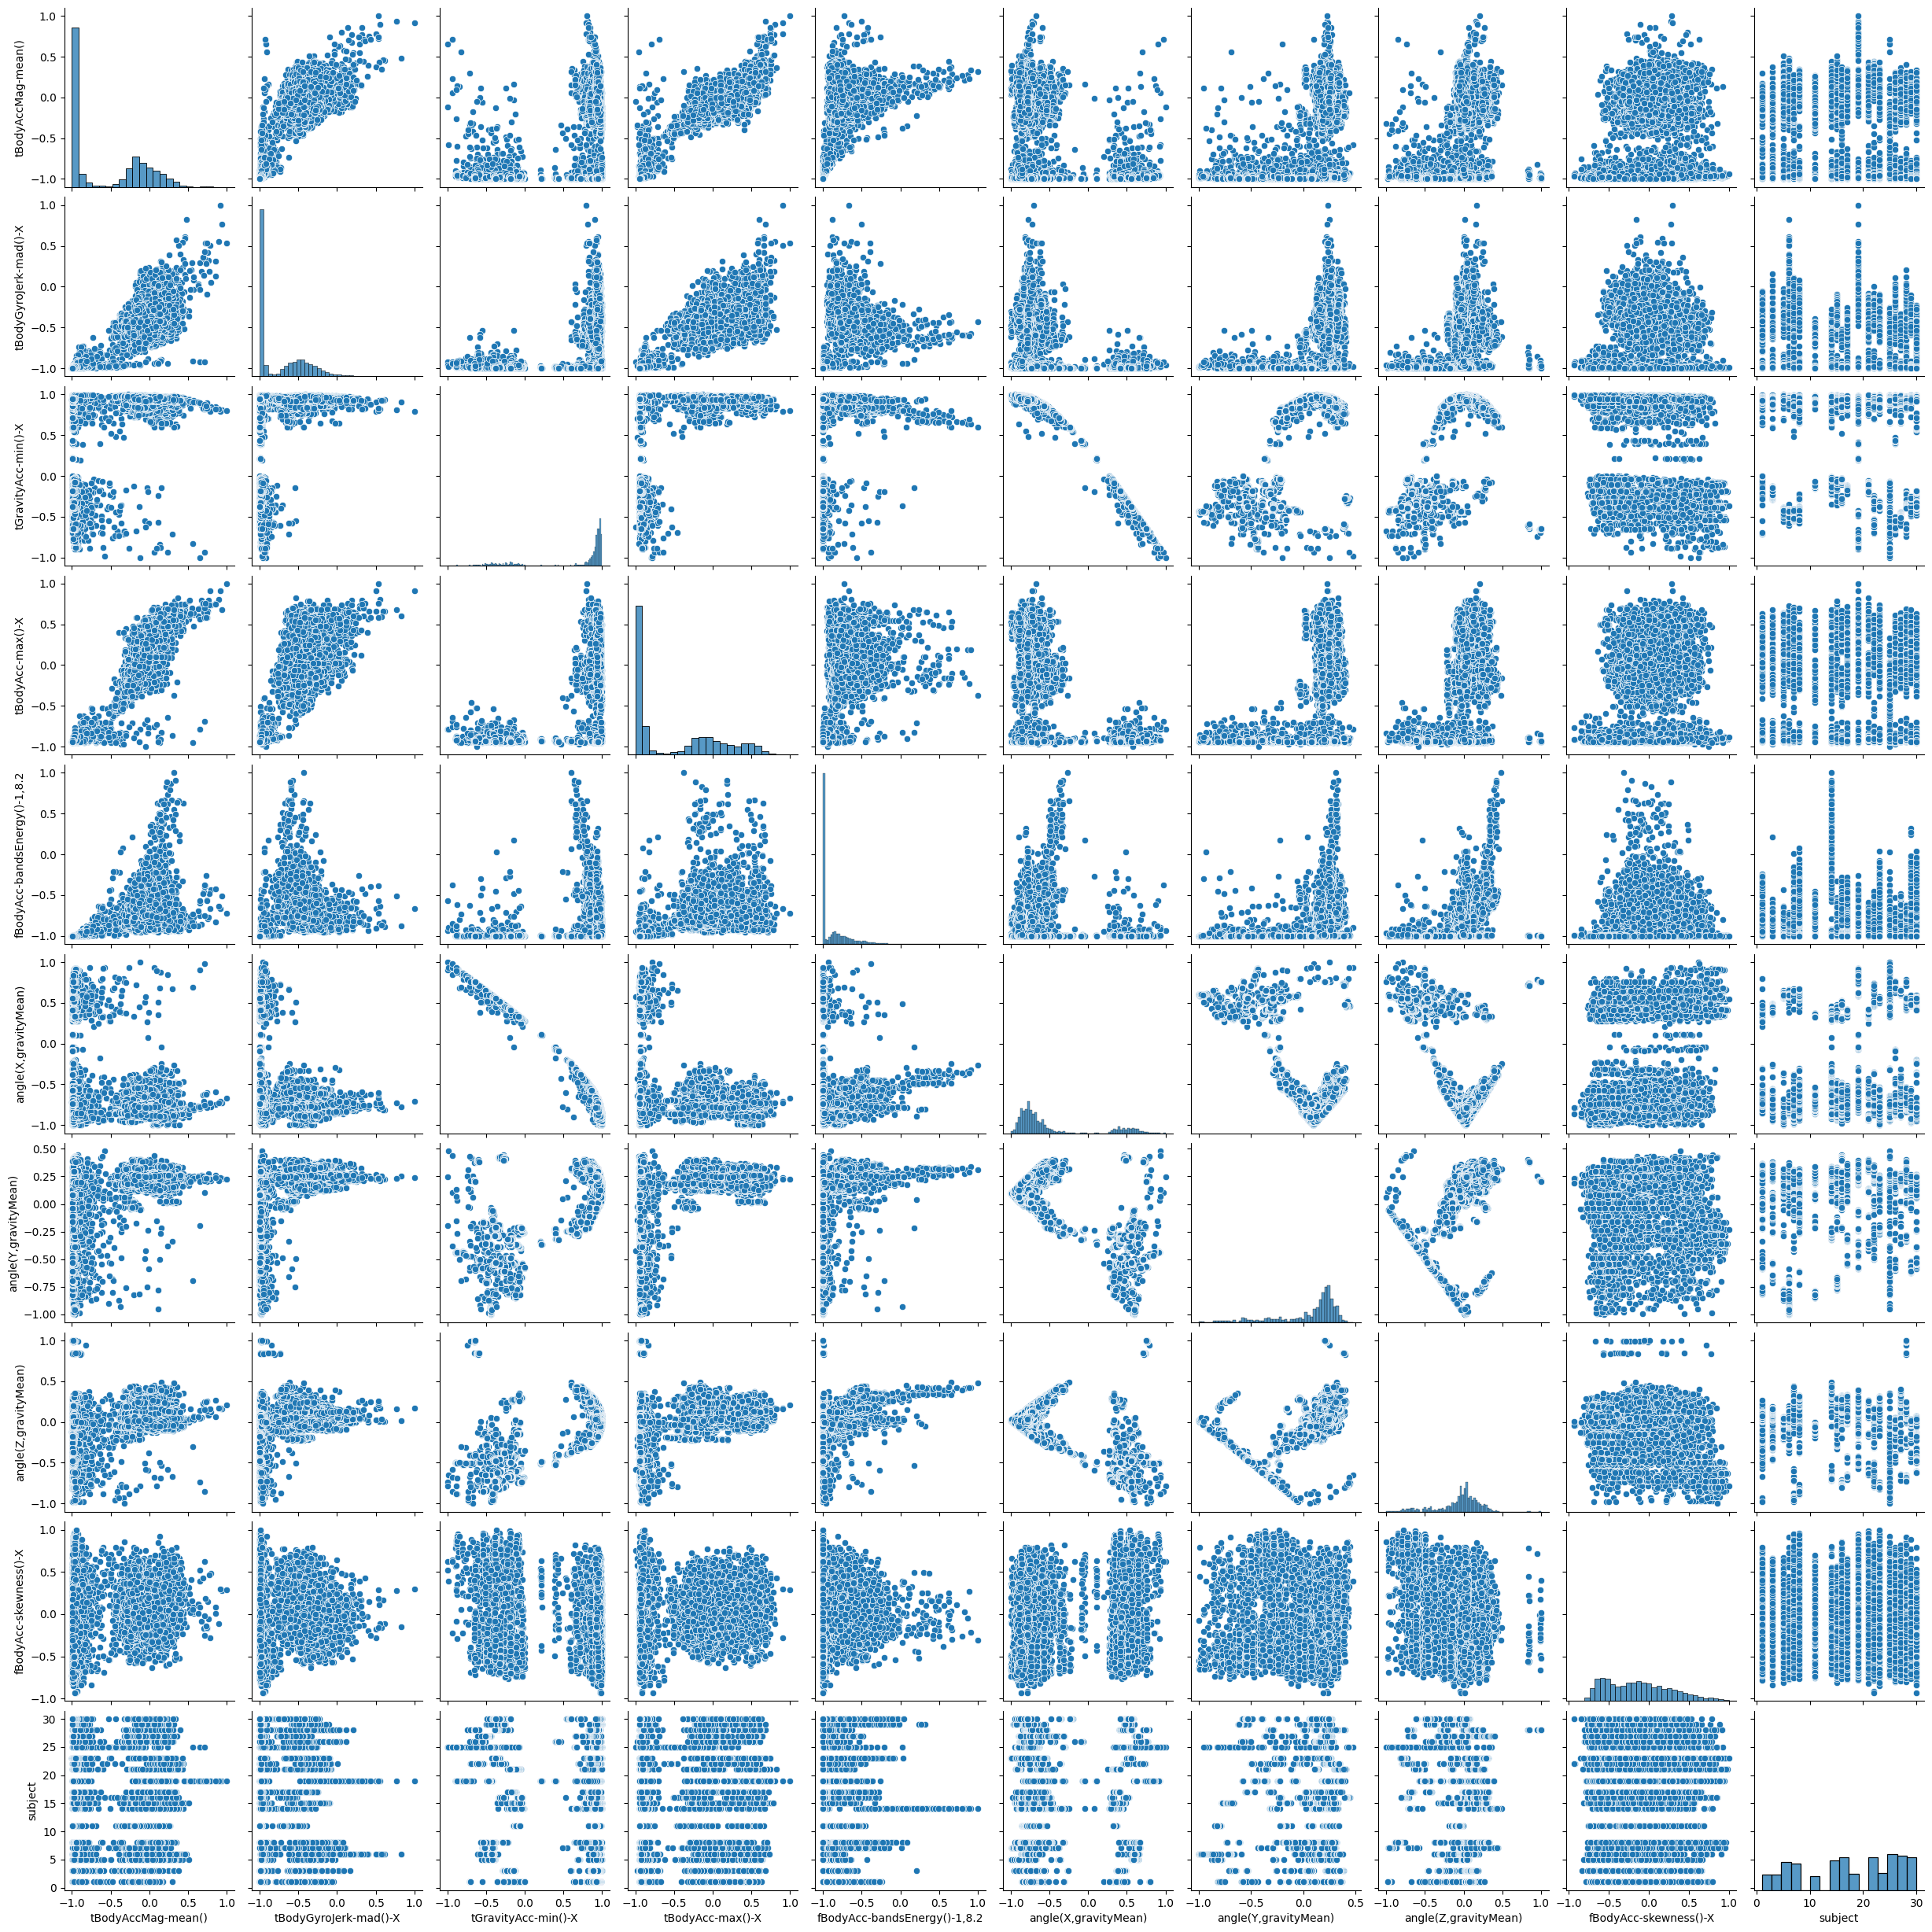

In [ ]:
sns.pairplot(train);

Анализировать такие графики очень неудобно, тк они мелкие и их огромное количество.\
Но можно также отметить, что на них достаточно легко заметить признаки с сильной и слабой корреляции(о которых я уже писала ранее), но это все же удобнее сделать на heatmap.

Попробуем проверить гипотезу. Отобразим плотность распределения (kde) `tBodyAccMag-mean()` для каждой из активностей. Можно поделить все активности на две группы, поэтому проведем линию.

Давайте первую группу называть статическими активностями, а вторую - динамическими.


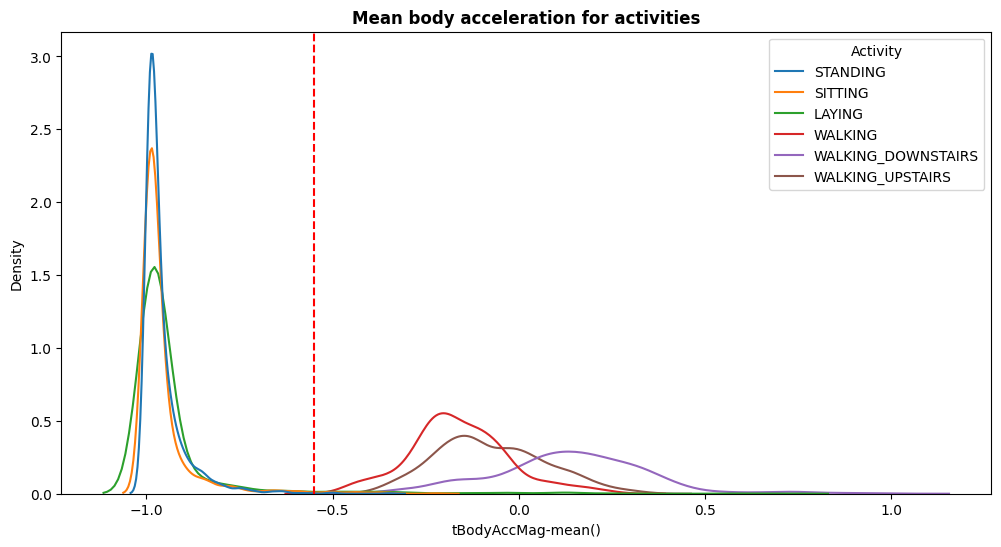

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Mean body acceleration for activities',fontweight='bold')
sns.kdeplot(data=train, x='tBodyAccMag-mean()', hue='Activity',common_norm=True)
plt.axvline(-0.55, color='red', linestyle='--')
plt.show()

In [ ]:
tr, fl = 0, 0
for i in range(len(train)):
  if train.loc[i, 'tBodyAccMag-mean()'] > -0.55:
    if train.loc[i, 'Activity'] in ['WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']:
      tr += 1
    else:
      fl += 1
print(tr / (fl + tr))

0.9800119331742243


Этот признак отражает среднюю величину ускорения тела, а значит, напрямую связан с интенсивностью(скоростью) движения. При статических активностях ускорение проктически не меняется(тело остается в стабильном положении), а при динамических имеет больший разброс(тело активно движется).\
Плотность у статистических активностей выше, потому что данные сгруппированы в небольшом интервале, а у активных наоборот.

Попробуем нарисовать "ящики с усами" для `angle(X,gravityMean)` с разделением по разным видам активности на данных train.

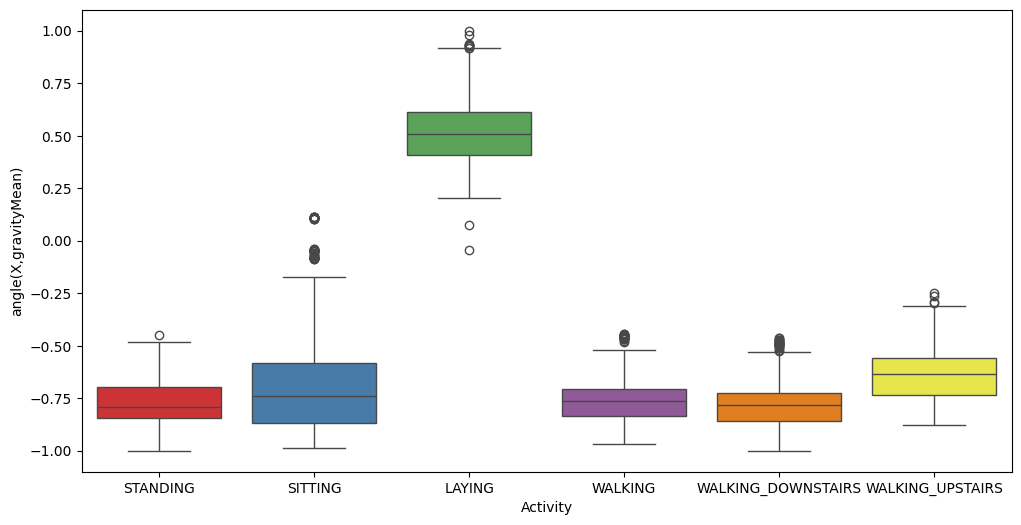

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(x="Activity", y="angle(X,gravityMean)", data=train, palette="Set1");


Категория "LAYING" очень сильно выделяется на фоне остальных, тк человек лежит в горизонтальном положении, а значит имеет наибольший угол между вертикальной осью гравитации, практически перпендикулярный.

Посмотрим теперь на `tBodyAcc-max()-X`. Визуализируйем скрипичные диаграммы для этого признака с разделением по активностям на всем train.

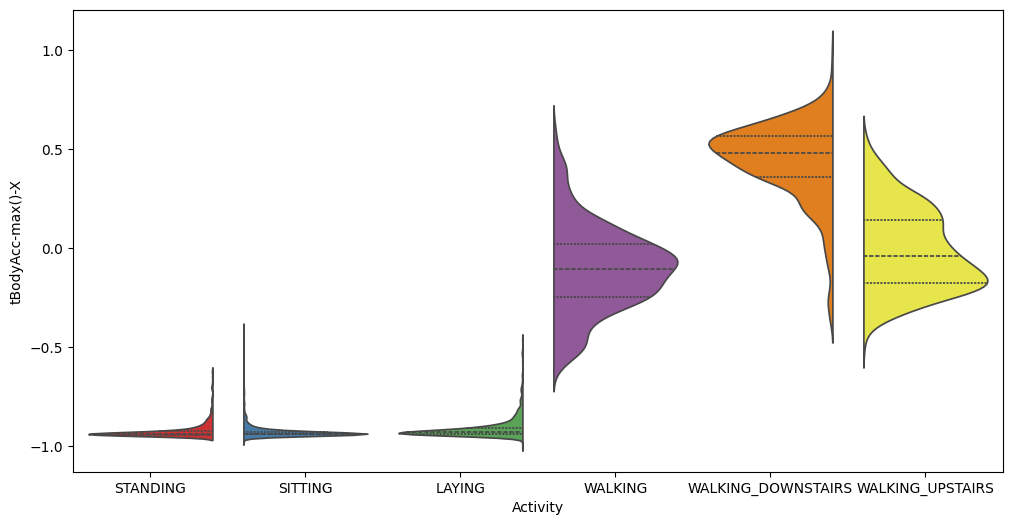

In [ ]:
plt.figure(figsize=(12, 6))

sns.violinplot(x="Activity", y="tBodyAcc-max()-X", data=train, palette="Set1", split=True, inner="quart");

WALKING_DOWNSTAIRS имеет наибольшие значения ускорения, распределение смещено вверх. Это объясняется тем, что при спуске тело подвергается более резким изменениям скорости и ускорения.

Мы уже можем с довольно хорошим качеством выделить две категории активности из шести. Продолжим.

Ранее уже упоминалось разделение на две группы активностей: статические и динамические. Пришла пора разделить датасет train на две части.

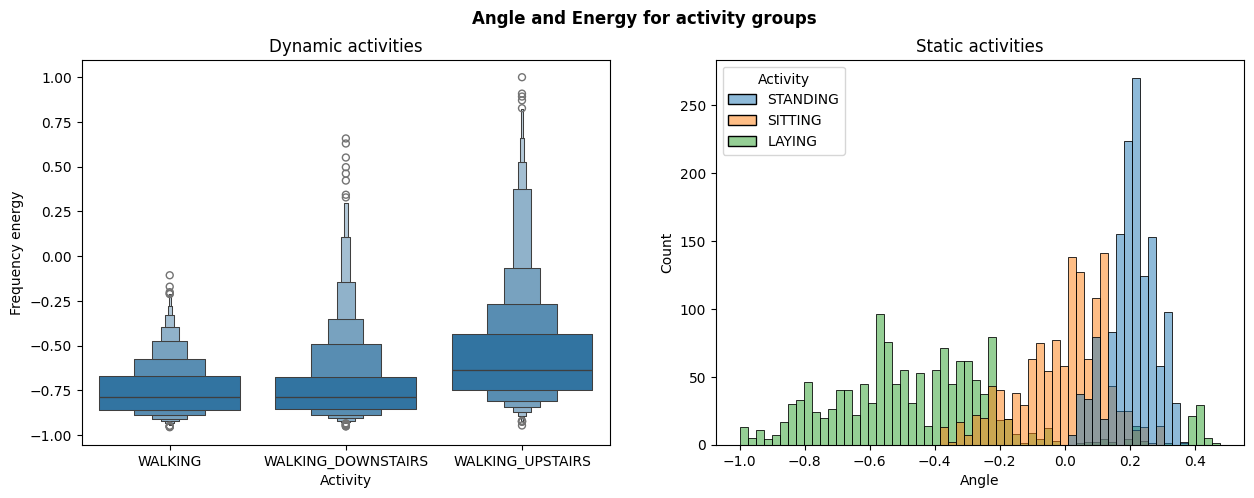

In [ ]:
dynamic_data = train[train['Activity'].isin(['WALKING','WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])]
static_data = train[train['Activity'].isin(['LAYING', 'SITTING', 'STANDING'])]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxenplot(x='Activity', y='fBodyAcc-bandsEnergy()-1,8.2', data=dynamic_data, ax=axes[0])
axes[0].set_title("Dynamic activities")
axes[0].set_ylabel("Frequency energy")

sns.histplot(static_data, x='angle(Y,gravityMean)', hue='Activity', common_norm=True, bins=60, ax=axes[1])
axes[1].set_title("Static activities")

plt.xlabel('Angle')
plt.ylabel('Count')
plt.suptitle("Angle and Energy for activity groups", fontweight='bold')
plt.show()

Можно выделить WALKING_UPSTAIRS, так как у него наибольшая энергия ускорения тела, то есть высокая интенсивность движений, из-за того, что часто меняются ускорения, и человек делет более резкие и мощные движения. \

У STANDING чаще всего встречается наибольший угол от оси Y, так как человек находится в вертикальном положении, а ось Y направлена горизонтально, а сидя человек больше наклоняется, что делает угол меньше.

Попробуем взять не один признак, а целых два.

Рассмотрим только статические активности. Будет снова два графика сразу. На первом графике будет боксплот распределения `fBodyAcc-skewness()-X` по активностям. А на втором попробуем взять не все наблюдения данной группы активностей, а только их часть.

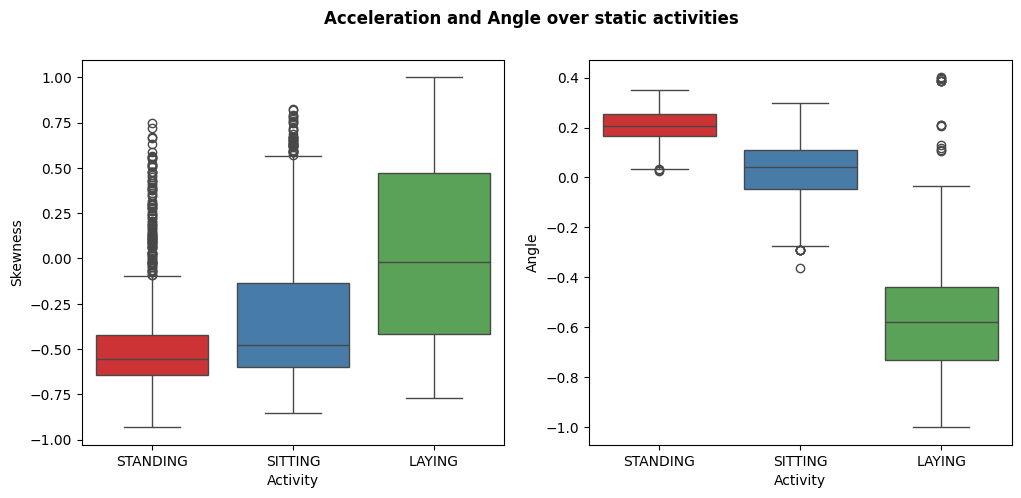

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="Activity", y="fBodyAcc-skewness()-X", data=static_data, palette="Set1", ax=axes[0])
axes[0].set_ylabel("Skewness")
static_data1 = static_data.loc[static_data['fBodyAcc-skewness()-X'] < -0.376]
sns.boxplot(x="Activity", y="angle(Y,gravityMean)", data=static_data1, palette="Set1", ax=axes[1])
axes[1].set_ylabel("Angle")
plt.suptitle("Acceleration and Angle over static activities", fontweight='bold');

На первом графике опять же выделяется "LAYING", а медианные значения двух других активностях очень схожи. На втором графике можно уже лучше выделить каждую категорию. Угол с осью У при сидении меньше, так как человек сидит не ровно вертикально, а наклоняется.

### Задание 14 (1 балл)

Вот и осталась лишь одна активность, которую мы никак не выделили. Попробуем и ее какими-то порогами отделить от всех остальных. Из доступных признаков, сначала посмотрим на распределение `tBodyAcc-max()-X` на динамических активностях.


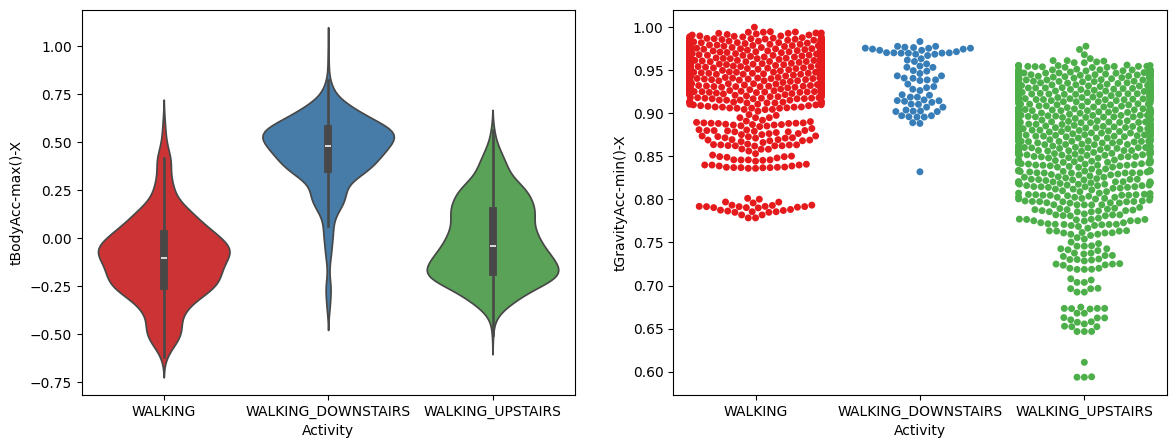

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.violinplot(x="Activity", y="tBodyAcc-max()-X", data=dynamic_data, palette="Set1", ax=axes[0])
dynamic_data1 = dynamic_data.loc[dynamic_data['tBodyAcc-max()-X'] < 0.157]
sns.swarmplot(x="Activity", y="tGravityAcc-min()-X", data=dynamic_data1, palette="Set1", ax=axes[1]);

На скрипичной диаграмме снова выделяется "WALKING_DOWNSTAIRS", а другие две достаточно схожи, поэтому построив также второй график, можно заметить, что у "WALKING" значения лежат значительно выше, чем у другой категории, так как при обычной ходьбе тело в находится более вертикально, и компонента гравитации по X изменяется не так сильно, разброс не такой больной, как при подъеме по лестнице.

Теперь надо сделать predict.

In [ ]:
def predict(df: pd.DataFrame):
  predictions = []
  for _, row in df.iterrows():
      if row["tBodyAccMag-mean()"] > -0.55:
          if 0.25 < row["tBodyAcc-max()-X"]:
              predictions.append("WALKING_DOWNSTAIRS")
          elif row["tGravityAcc-min()-X"] > 0.9:
              predictions.append("WALKING")
          else:
              predictions.append("WALKING_UPSTAIRS")
      else:
          if 0.25 < row["angle(X,gravityMean)"]:
              predictions.append("LAYING")
          elif 0.1  < row["angle(Y,gravityMean)"]:
              predictions.append("STANDING")
          else:
              predictions.append("SITTING")

  return predictions

def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

In [ ]:
train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

Accuracy on train set => 0.8127040261153428
Accuracy on test set => 0.7869019341703427


Отличный результат!!!